In [1]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.7 MB/s eta 0:00:00


In [2]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")


matplotlib version: 3.7.1
numpy version: 1.26.4
tiktoken version: 0.7.0
torch version: 2.4.0+cu121


In this notebook, we implement the training loop and code for basic model evaluation to pretrain an LLM

In [4]:
import torch
from supplementary import GPTModel


GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [5]:
import tiktoken
from supplementary import generate_text_simple, text_to_token_ids,token_ids_to_text

In [6]:
tokenizer = tiktoken.get_encoding('gpt2')
start_context = 'every effort moves you '

token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(start_context,tokenizer=tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M['context_length']

)

In [7]:
text = token_ids_to_text(token_ids=token_ids,tokenizer=tokenizer)

In [8]:
print(text)

every effort moves you Gr dramJoined Starcraft cryptic complementary sauces nylon Barneslevision


### Preparing the dataset Loaders

We use short dataset for training the LLM (a short story 'the-verdict.txt')


In [9]:
with open('the-verdict.txt','r') as f:
    text_data = f.read()

In [10]:
len_token =len( tokenizer.encode(text_data))

In [11]:
print(len_token) # total training data token. for now we use low token for educational purpose

5145


In [12]:
print(text_data[1:100])

 HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g


In [13]:
enc_sample = tokenizer.encode(text_data)[50:]


context_size = 5

for i in range(1, context_size + 1):
    x = enc_sample[:i]
    y = enc_sample[i]
    print(tokenizer.decode(x),"-->",tokenizer.decode([y]))

 and -->  established
 and established -->  himself
 and established himself -->  in
 and established himself in -->  a
 and established himself in a -->  vill


In [14]:
# dataset split before loading to DataLoader

train_ratio = 0.9
split_idx =  int (train_ratio * len(text_data))

train_data = text_data[:split_idx]
val_data = text_data[split_idx:]



In [15]:
print(len(val_data))

2048


In [16]:
from torch.utils.data import DataLoader, Dataset



In [17]:
class GPTDatasetV1(Dataset):
    def __init__(self,text,tokenizer, max_length, stride):
        self.input_ids  = []
        self.target_ids = []

        token_ids = tokenizer.encode(text,allowed_special={'<|endoftext|>'})

        for i in range(0,len(token_ids) - max_length, stride): # to move upto length lest than max in order to take the tokens
            input_chunk = token_ids[i : max_length + i]
            target_chunk = token_ids[i+1 : max_length + i + 1 ]      # window slides as per stride, so it takes the value of
                                                                #winodw +1 then move accrodingly

            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __getitem__(self, index) :
        return self.input_ids[index],self.target_ids[index]

    def __len__(self):
        return len(self.input_ids)




In [18]:
datasetv1 = GPTDatasetV1(text= 'hi hello anil how are you,sadf',tokenizer= tokenizer,max_length=2,stride=1)

In [19]:
# now we can create an efiicicient dataloader

def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader


In [20]:
dataloader= create_dataloader_v1(train_data,batch_size=1,max_length=5,stride=1,shuffle=False)

In [21]:
data_iter = iter(dataloader)
first_batch  = next(data_iter)

In [22]:
print(first_batch)

[tensor([[  40,  367, 2885, 1464, 1807]]), tensor([[ 367, 2885, 1464, 1807, 3619]])]


In [23]:
# Now we prepare the dataloaders for train and val dataset

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=True,
    shuffle=True,
    num_workers= 0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=False,
    shuffle=False,
    num_workers= 0
)

#To explore: What does the drop_last in DataLoader do?

In [24]:
#test the working of dataloader

print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


#### Cacluate the LOSS

In [25]:
from supplementary import calc_loss_loader

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123)

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583266364204
Validation loss: 10.981104850769043


In [27]:
from supplementary import (
    calc_loss_batch,
    evaluate_model,
    generate_and_print_sample
)


In [28]:
def train_model_simple(model,train_loader,val_loader,optimizer,device,num_epochs,eval_freq,eval_iter,start_context,tokenizer):

    #list to trak losses and token seen

    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):

        model.train() #set to training mode

        for input_batch,target_batch in train_loader:

            optimizer.zero_grad()

            loss = calc_loss_batch(input_batch,target_batch,model,device)
            loss.backward()
            optimizer.step() #update model weights using loss gradient

            tokens_seen += input_batch.numel() # Returns the total number of elements in the input tensor.
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model,train_loader,val_loader,device,eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)

                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

         # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


In [29]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=1, eval_iter=1,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 10.062, Val loss 9.930
Ep 1 (Step 000001): Train loss 9.287, Val loss 9.388
Ep 1 (Step 000002): Train loss 9.344, Val loss 9.129
Ep 1 (Step 000003): Train loss 8.962, Val loss 8.887
Ep 1 (Step 000004): Train loss 8.675, Val loss 8.639
Ep 1 (Step 000005): Train loss 8.400, Val loss 8.336
Ep 1 (Step 000006): Train loss 7.634, Val loss 8.046
Ep 1 (Step 000007): Train loss 7.621, Val loss 7.748
Ep 1 (Step 000008): Train loss 6.855, Val loss 7.473
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000009): Train loss 7.302, Val loss 7.239
Ep 2 (Step 000010): Train loss 6.349, Val loss 7.044
Ep 2 (Step 000011): Train loss 6.247, Val loss 6.899
Ep 2 (Step 000012): Train loss 6.184, Val loss 6.794
Ep 2 (Step 000013): Train loss 5.903, Val loss 6.716
Ep 2 (Step 000014): Train loss 6.500, Val loss 6.661
Ep 2 (Step 000015): Train loss 6.509, Val loss 6.617
Ep 2 (Step 000016): Train loss 5.945, Val loss 6.584
Ep 2 (Step 000017): Train

In [31]:
torch.save(model.state_dict(), "model.pth")

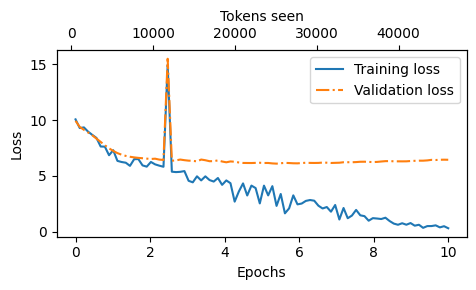

In [32]:
from supplementary import plot_losses


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [45]:
start_context = "You are looking  "

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer).to(device),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 You are looking  'd never touched a brush."






In [47]:
# load the model in new session

import torch

# Imports from a local file
from supplementary import GPTModel


model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval();

<ipython-input-47-a1a952e33aae>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth", map_location=device))
